# Approximate Singular Value Decomposition 

### Synopsis

I use the eigenvalue decomposition method whenever I implement any Manifold Learning method. The general steps one must take in order to implement these methods would be:

1. Construct a Connectivity Matrix
2. Solve the Eigenvalue Decomposition Problem
3. Extract the k-smallest nontrivial eigenvalues and the corresponding eigenvectors to either extract the embedding or project the data into the new space where the embedding is present.

Now, step 2 is very computationally heavy so I am looking for methods which can reduce the computaitonal burden. From my understanding, the Approximate Singular Value Decomposition (ASVD) method uses the theory of random approximations of spectral decompositions to find the best rank-k  approximation of a matrix A. This sounds particularly useful because it will speed up the entire algorithm process and it is a method that has some pretty good theoretical guarantees to ensure that we have a good solution.

### Resources

I will be using the following papers to complete my self tutorial:

# Theory

* Randomized Approximate of Operators and their Spectral Decomposition for Diffusion Based Embeddings of Hetergeneous Data
    - Czaja et al. - [Paper][1]
* A randomized algorithm for principal component analysis
    - Rokhlin et al. - [Paper][2]
* Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions
    - Halko et al. - [Paper][3]
* A randomized algorithm for the decomposition of matrices
    - Martisson et al. - [Paper][8]
   
# Practical

* A Practical Guide to Randomized Algorithms in MATLAB
    - [Paper][10] | [Code][11]
* Course: Fast AI - Randomized SVD 
    - [github](https://github.com/fastai/randomized-SVD)


# Source Codes

I will use the following code as a guide for implementing the steps in the paper:

* Github user - [gist][4]
* Github user - [github][6]
* Facebook: Fast Randomized PCA/SVD - [github][5]
* Scikit-Learn: Randomized SVD - [github][7]
* Mu Li: Randomized SVD - [github][9]
    
    
[1]: http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=7330267&tag=1
[2]: http://arxiv.org/pdf/0809.2274.pdf
[3]: https://arxiv.org/pdf/0909.4061
[4]: https://gist.github.com/alextp/662433
[5]: https://github.com/facebook/fbpca/blob/master/fbpca.py
[6]: https://github.com/ktaneishi/pyredsvd
[7]: https://github.com/scikit-learn/scikit-learn/blob/51a765acfa4c5d1ec05fc4b406968ad233c75162/sklearn/utils/extmath.py
[8]: https://math.berkeley.edu/~strain/273.F10/martinsson.tygert.rokhlin.randomized.decomposition.pdf
[9]: https://github.com/mli/nystrom/blob/master/rsvd.m
[10]: https://arxiv.org/pdf/1505.07570.pdf
[11]: https://github.com/wangshusen/RandMatrixMatlab

## Algorithm Walkthrough

Suppose we have a real matrix A of size $m\times n$. This can be typically decomposed via regular SVD as

$$A=U\Sigma V^T$$

where:
* $U$ is a real unitary $m\times m$ matrix
* $V$ is a real unitary $n \times n$ matrix
* $\Sigma$ is a real $m\times n$ diagonal matrix

A well known idea is that the best rank-$k$ approximation of A is given by

$$A=\tilde{U}\tilde{\Sigma}\tilde{V}^T$$

where:
* $\tilde{U}$ is a real unitary $m\times k$ matrix
* $\tilde{V}$ is a real unitary $n \times k$ matrix
* $\tilde{\Sigma}$ is a real $k\times k$ diagonal matrix
We now want to form a Gaussian matrix

### Step 1 - Gaussian Matrix

Let $A$ be a real $m\times n$ matrix. 

In [39]:
# get some random matrix
from sklearn.datasets import make_spd_matrix

A = make_spd_matrix(100, random_state=0)

m = A.shape[0]  # left dimension of A
n = A.shape[1]  # right dimension of A

# choose some k singular values we want
k = 10

Construct a matrix, $G$, of i.i.d. standard Gaussian random variables, s.t. the matrix is size $l\times m$ where $k<l\leq m-k$.

In [40]:
# choose some l that satisfies the inequality listed above
l = 20

# assert that the inequality is satisfied
def check_l(l):
    assert l > k and l <= (m-k), "Your choice of l must satisfy the inequality."
    return l

# check my value of l
l = check_l(l)

# create gaussian matrix
import numpy as np

G = np.random.normal(size=(l,m))

### Step 2 - Compute Product

Compute the product of the following:

$$S=G(AA^T)^iA$$

where $i \in \mathbb{N}$. To get an idea of the dimensions, it is:

$$S=G_{l\times m}(A_{m \times n}A_{n \times m}^T)^iA_{m \times n}$$

This is actually a pretty involved product so I'm going to break down the steps even further.

##### Compute the square matrix

It would seem that the product $AA^T$ is only need because $A$ is an $m \times n$ matrix. This would not be needed if $A=A^T$, i.e. a symmetric matrix. In fact, it might be the case that doing $AA^T$ for a symmetric matrix would count as doing an extra iteration for the next step.

In [41]:
# compute the square matrix
A_square = np.dot(A, A.T)

##### Compute the Power of the square matrix

This involves the $(AA^T)^{i}$. I'm pretty sure that $i \in \mathbb{N}$ and by increasing $i$ increases the accuracy of the method.

In [42]:
# compute the matrix power
i = 2
A_power = np.linalg.matrix_power(A_square,i)

##### Now Compute the actual product

In [43]:
# compute the product for step 2
S = np.dot(G,np.dot(A_square,A))

### Step 3. Compute the Pivoted QR-Decomposition

So, we need to use a pivoted $QR$-decomposition on the $S^T$ matrix computed in step 2 so that we get

$$S^T=QR$$

where $Q$ is an $n \times l$ matrix with orthonormal columns. 

In [44]:
# compute the QR-decomposition on S transpose
Q, R = np.linalg.qr(S.T,mode='complete')

There are so many options for the QR decomposition in the numpy package. The 'reduced' mode returns with reduced dimensions so I decided to use the 'complete' mode just in case it cuts some stuff out that we need for later. I could do some experiments later because I suspect that the reduced method may be a little bit faster. 

**Note:** Not sure if they have a sparse package in the scipy library. May have to figure out another way to do it.

### Step 4. Compute the SVD of $T:=AQ$

Now we compute the following SVD

$$T=\tilde{U}\tilde{\Sigma}W^T$$

If we let $T:=AQ$, we get a much faster SVD computation than just performing SVD on $A$ alone because $T$ is size $m \times l$.

In [45]:
T = np.dot(A,Q)
U_hat, Sigma_hat, W = np.linalg.svd(T)

### Step 5. Compute $\tilde{V}$

This is done by the following assignment:

$$\tilde{V}:=QW$$

In [46]:
V_hat = np.dot(Q,W)

### Step 6. Extract $U$, $\Sigma$, and $V$

Now we can extract the necessary SVD from our algorithm.

* Extract upper left $m\times k$ block from $\tilde{U}$
* Extract upper left $n\times k$ block from $\tilde{V}$
* Extract upper left $k\times k$ block from $\tilde{\Sigma}$


In [47]:
U = U_hat[:m, :k]
V = V_hat[:n, :k]
Sigma = Sigma_hat[:k]

## ASVD Function

To get away from the imperative style tutorial above, I'm defining a function that contains all of the elements that I outlined above.

In [48]:
def asvd(A, n_components, size_gauss, pow_iter):
    
    # get components
    m = A.shape[0]; n = A.shape[1]
    k = n_components
    l = size_gauss
    i = pow_iter
    assert l > k and l <= (m-k), "Your choice of l must satisfy the inequality."
    
    # perform ASVD
    G = np.random.normal(size=(l,m))
    A_square = np.dot(A, A.T)
    A_power = np.linalg.matrix_power(A_square,i)
    S = np.dot(G,np.dot(A_square,A))
    Q, R = np.linalg.qr(S.T,mode='complete')
    T = np.dot(A,Q)
    U_hat, Sigma_hat, W = np.linalg.svd(T)
    V_hat = np.dot(Q,W)
    
    # extract n_components
    U = U_hat[:m, :k]
    V = V_hat[:n, :k]
    Sigma = Sigma_hat[:k]
    
    return U, Sigma, V

## More Compact ASVD Function

The next step is to reduce the memory used for this function. I don't need to be implementing all these  assignments when I can keep those contained within functions; really one of the highlights of python.

## Smallest Eigenvalues and Eigenvectors

So the above method computes the largest eigenvalues of the given matrix. In order to compute the smallest eigenvalues, we have to do a trick:

1. Let $k=1$. 
2. Use ASVD to compute the largest $k$ eigenvalues of the matrix, i.e. $\sigma_1$.
3. Transform A like so: $\mathbf{A}' = 2\sigma_1 \mathbf{I}-\mathbf{A}$.
4. Use ASVD to solve for the largest $k$' eigenvalues and eigenvectors of the matrix, $\mathbf{A}'$.
5. The smallest eigenvalues and eigenvectors are given by: $\Sigma=2\sigma_1 \mathbf{I}-\Sigma'$

**Note**: We can actually keep the same eigenvectors as the $\mathbf{A}'$ matrix for the smallest eigenvalues.

Let's have the following eigenvalue formula:

\begin{equation}
\mathbf{A}\vec{x}=\lambda\vec{x}
\end{equation}

Now let's add some arbitrary scaling parameter $\gamma \mathbf{I}$ to the $\mathbf{A}$. Using the above equation, we can deduce that:

\begin{align}
\left(\gamma \mathbf{I+A}\right)\vec{x} &= \gamma \mathbf{I} \vec{x} + \mathbf{A}\vec{x} \\
    &= \gamma \vec{x} + \lambda \vec{x}\\
    &= \left( \gamma + \lambda \right) \vec{x}
\end{align}

Therefore, $\gamma + \lambda$ is an eigenvalue but $\vec{x}$ is still the same eigenvector.


 

##### Example

In [49]:
# set parameters
n_components = 5  # i'm looking for the 5 smallest and largest eigenvectors for the same matrix A
size_gauss = 30
pow_iter = 20

# solve for the largest eigenvalue
_, Sigma_large, _ = asvd(A, n_components=n_components,
                   size_gauss=size_gauss, 
                   pow_iter=pow_iter)

# transform the original matrix A to A'
A_new = 2*Sigma_large[0]*np.eye(A.shape[0])-A

# solve for the largest k components of the matrix A'
_, Sigma, _ = asvd(A_new, n_components=n_components,
                   size_gauss=size_gauss,
                   pow_iter=pow_iter)

# use transformation to find the smallest eigenvalues
Sigma_small = 2*Sigma_large[0]-Sigma

# find all of the eigenvalues
_, Sigma, _ = np.linalg.svd(A)

# just check to see if the results are the same
print('The largest {k} eigenvalues for A:\n{eig}'.format(k=n_components,eig=Sigma_large))
print('Using the SVD function:\n{eig}'.format(eig=Sigma[:n_components]))
print('The same? {ans}'.format(ans=np.linalg.norm(Sigma_large - Sigma[:n_components])<1E-10))
print('The smallest {k} eigenvalues for A:\n{eig}'.format(k=n_components,eig=Sigma_small))
print('Using the SVD function:\n{eig}'.format(eig=Sigma[::-1][:n_components]))
print('The same? {ans}'.format(ans=np.linalg.norm(Sigma_small - Sigma[::-1][:n_components])<1E-10))

The largest 5 eigenvalues for A:
[100.49708086   0.99603269   0.99283061   0.98404493   0.97890796]
Using the SVD function:
[100.49708086   0.99603269   0.99283061   0.98404493   0.97890796]
The same? True
The smallest 5 eigenvalues for A:
[0.00258032 0.00694713 0.01430953 0.02844083 0.03210657]
Using the SVD function:
[0.00258032 0.00694713 0.01430953 0.02844083 0.03210657]
The same? True


#### Where are the eigenvectors in an SVD?

I'll just do an experiment where I compute the solution to the generalized eigenvalue problem using SVD and some other method.

In [50]:
from scipy.linalg import eig
U={}; Sigma={}; V={}
U['np'], Sigma['np'], V['np'] = np.linalg.svd(A)
U['asvd'], Sigma['asvd'], V['asvd'] = asvd(A, n_components=10,
                                           size_gauss=size_gauss,
                                           pow_iter=pow_iter)
eigVals = {}; eigVecs = {}
eigVals['scipy'], eigVecs['scipy'] = eig(a=A)
print(V['np'].shape, V['asvd'].shape, eigVecs['scipy'].shape)
print(V['np'][:5, :n_components])
print(V['asvd'][:5, :n_components])
print(eigVecs['scipy'][:5, :n_components])
print('\n\n\n')
print(Sigma['np'][:5])
print(Sigma['asvd'][:5])
print(eigVals['scipy'][:5])

(100, 100) (100, 10) (100, 100)
[[-0.05956788 -0.08791196 -0.17417145 -0.04740637  0.00759859]
 [-0.00759328 -0.23749074 -0.05009837 -0.08681157 -0.08235621]
 [ 0.11349362  0.0180285  -0.10913929 -0.17421939 -0.07026755]
 [-0.1997493   0.01389396  0.0518404   0.07702102 -0.17090324]
 [ 0.00489798  0.00536418  0.1232994   0.10461716 -0.19734486]]
[[-0.05956139  0.16587084  0.19881521 -0.10309956 -0.12184645]
 [-0.08791162  0.07951956  0.00039253 -0.09658149  0.0015464 ]
 [-0.17417317  0.05115577  0.06641891  0.009945    0.18215605]
 [-0.04740436 -0.07802608  0.00304858  0.2878056   0.03702041]
 [ 0.00759136 -0.01111304 -0.20716936 -0.04216575  0.10729865]]
[[ 0.05956788 -0.00759328  0.11349362 -0.1997493  -0.00489798]
 [ 0.08791196 -0.23749074  0.0180285   0.01389396 -0.00536418]
 [ 0.17417145 -0.05009837 -0.10913929  0.0518404  -0.1232994 ]
 [ 0.04740637 -0.08681157 -0.17421939  0.07702102 -0.10461716]
 [-0.00759859 -0.08235621 -0.07026755 -0.17090324  0.19734486]]




[100.49708086   

/Users/eman/anaconda3/envs/kernellib/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


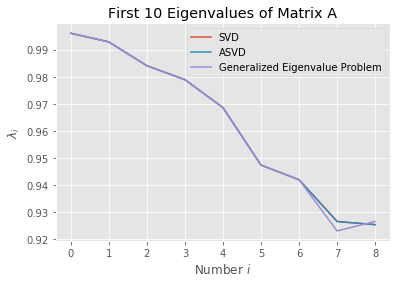

In [51]:
# plot the two solutions and compare the values
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(Sigma['np'][1:10], label="SVD")
ax.plot(Sigma['asvd'][1:10], label='ASVD')
ax.plot(eigVals['scipy'][1:10], label='Generalized Eigenvalue Problem')
ax.set_title('First {k} Eigenvalues of Matrix A'.format(k=k))
ax.set_ylabel('$\lambda_i$')
ax.set_xlabel('Number $i$')
plt.legend(loc='upper right')

plt.show()

## Comparing Implementations

In [52]:
# get some random matrix
from sklearn.datasets import make_spd_matrix

A = make_spd_matrix(100, random_state=0)

m = A.shape[0]  # left dimension of A
n = A.shape[1]  # right dimension of A

# choose some k singular values we want
k = 20

# set parameters
size_gauss = 60
pow_iter = 50

# initialize the dictionary of values
U={}; Sigma={}; V={}

##### Numpy's Implementation

In [53]:
import numpy as np

U['np'], Sigma['np'], V['np'] = np.linalg.svd(A)

Sigma['np'] = Sigma['np'][:k]
V['np'] = V['np'].T[:,:k]

##### Facebook PCA's Implementation

In [54]:
# import fbpca as fbpca


# Sigma['fbpca'], V['fbpca'] = fbpca.eigenn(A=A, k=k)

##### Scikit-Learn's Implementation

In [55]:
from sklearn.utils.extmath import randomized_svd
# randomized SVD
U['rscikit'], Sigma['rscikit'], V['rscikit'] = randomized_svd(M=A, n_components=k,
                                                           n_iter=pow_iter)
V['rscikit'] = V['rscikit'].T

##### My Implementation

In [56]:
U['asvd'], Sigma['asvd'], V['asvd'] = asvd(A, n_components=k,
                                           size_gauss=size_gauss,
                                           pow_iter=pow_iter)

##### Scipy Sparse Implementation

In [57]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

U['scipy'], Sigma['scipy'], V['scipy'] = svds(A=csr_matrix(A),k=20,
                                              which='LM', 
                                              maxiter=pow_iter)

V['scipy'] = V['scipy'].T

### Computing the Spectral Norms

In [58]:
# Copied from FBPCA algorithm
import scipy 

def diffsnorms(A, S, V, n_iter=20):
    """
    2-norm accuracy of a Schur decomp. of a matrix.
    Computes an estimate snorm of the spectral norm (the operator norm
    induced by the Euclidean vector norm) of A-VSV', using n_iter
    iterations of the power method started with a random vector;
    n_iter must be a positive integer.
    Increasing n_iter improves the accuracy of the estimate snorm of
    the spectral norm of A-VSV'.
    Notes
    -----
    To obtain repeatable results, reset the seed for the pseudorandom
    number generator.
    Parameters
    ----------
    A : array_like
        first matrix in A-VSV' whose spectral norm is being estimated
    S : array_like
        third matrix in A-VSV' whose spectral norm is being estimated
    V : array_like
        second matrix in A-VSV' whose spectral norm is being estimated
    n_iter : int, optional
        number of iterations of the power method to conduct;
        n_iter must be a positive integer, and defaults to 20
    Returns
    -------
    float
        an estimate of the spectral norm of A-VSV' (the estimate fails
        to be accurate with exponentially low probability as n_iter
        increases; see references DS1_, DS2_, and DS3_ below)
    Examples
    --------
    >>> from fbpca import diffsnorms, eigenn
    >>> from numpy import diag
    >>> from numpy.random import uniform
    >>> from scipy.linalg import svd
    >>>
    >>> A = uniform(low=-1.0, high=1.0, size=(2, 100))
    >>> A = A.T.dot(A)
    >>> (U, s, Va) = svd(A, full_matrices=False)
    >>> A = A / s[0]
    >>>
    >>> (d, V) = eigenn(A, 2)
    >>> err = diffsnorms(A, diag(d), V)
    >>> print(err)
    This example produces a rank-2 approximation V diag(d) V' to A
    such that the columns of V are orthonormal and the entries of d
    are nonnegative and are nonincreasing.
    diffsnorms(A, diag(d), V) outputs an estimate of the spectral norm
    of A - V diag(d) V', which should be close to the machine
    precision.
    References
    ----------
    .. [DS1] Jacek Kuczynski and Henryk Wozniakowski, Estimating the
             largest eigenvalues by the power and Lanczos methods with
             a random start, SIAM Journal on Matrix Analysis and
             Applications, 13 (4): 1094-1122, 1992.
    .. [DS2] Edo Liberty, Franco Woolfe, Per-Gunnar Martinsson,
             Vladimir Rokhlin, and Mark Tygert, Randomized algorithms
             for the low-rank approximation of matrices, Proceedings of
             the National Academy of Sciences (USA), 104 (51):
             20167-20172, 2007. (See the appendix.)
    .. [DS3] Franco Woolfe, Edo Liberty, Vladimir Rokhlin, and Mark
             Tygert, A fast randomized algorithm for the approximation
             of matrices, Applied and Computational Harmonic Analysis,
             25 (3): 335-366, 2008. (See Section 3.4.)
    See also
    --------
    eigenn, eigens
    """

    (m, n) = A.shape
    (m2, k) = V.shape
    (k2, k3) = S.shape

    assert m == n
    assert m == m2
    assert k == k2
    assert k2 == k3

    assert n_iter >= 1

    if np.isrealobj(A) and np.isrealobj(V) and np.isrealobj(S):
        isreal = True
    else:
        isreal = False

    # Promote the types of integer data to float data.
    dtype = (A * 1.0).dtype

    #
    # Generate a random vector x.
    #
    if isreal:
        x = np.random.normal(size=(n, 1)).astype(dtype)
    else:
        x = np.random.normal(size=(n, 1)).astype(dtype) \
            + 1j * np.random.normal(size=(n, 1)).astype(dtype)

    x = x / scipy.linalg.norm(x)

    #
    # Run n_iter iterations of the power method.
    #
    for it in range(n_iter):
        #
        # Set y = (A-VSV')x.
        #
        y = np.dot(A, x) - V.dot(S.dot(V.conj().T.dot(x)))
        #
        # Set x = (A'-VS'V')y.
        #
        x = np.dot(y.conj().T, A).conj().T \
            - V.dot(S.conj().T.dot(V.conj().T.dot(y)))

        #
        # Normalize x, memorizing its Euclidean norm.
        #
        snorm = scipy.linalg.norm(x)
        if snorm == 0:
            return 0
        x = x / snorm

    snorm = np.sqrt(snorm)

    return snorm

In [59]:
# compute the norm for the difference between implementations
norm = {}

methods = ['rscikit', 'asvd', 'np', 'scipy']

for method in methods:
#     S = Sigma[method]
#     v = V[method]
#     print(S, v)
    norm[method] = diffsnorms(A, np.diag(Sigma[method]), V[method])
    print('Norm for {m} method: {n}'.format(m=method,n=norm[method]))
    

Norm for rscikit method: 0.8394632337936275
Norm for asvd method: 0.9374835480196004
Norm for np method: 0.8347980612755976
Norm for scipy method: 0.8270229685200706


I'll be honest, I have no idea what's a good or bad spectral norm value. Typically the lower the number the better. But both numbers are so close to 1 so maybe the higher the number the better? Who knows..